In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_recall_fscore_support,precision_score,recall_score,f1_score
import random
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

plt.style.use('ggplot')

def randomised_search_cv(classifier,parameters,df,col_list,labels,num_iter=500):
    accuracy_list = []
    RSEED = 42
    for i in range(num_iter):
        
        if i%(num_iter/4)==0:
            print(str(i)+"iterations ran")

        param_iter = {}
        for key,value in parameters.items():
            param_iter[key] = random.choice(value)
        clf = classifier(random_state=RSEED, **param_iter)

        scores = cross_val_score(clf, df[col_list], labels, cv=5,scoring="f1")
        accuracy_list += [(param_iter, np.mean(scores))]

    accuracy_list.sort(key = lambda x: x[1])
    print(accuracy_list[-1])
    return accuracy_list[-1]

def generate_prc(y_true, y_proba):
    return precision_recall_curve(y_true, y_proba[:, 1])

def plot_curves(clf_curves, ctype='roc', legend=False):
    clfs = clf_curves.keys()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    for clf, curve in clf_curves.items():
        if ctype == 'roc':
            x = curve[0]
            y = curve[1]
            xlabel = 'False Positive Rate'
            ylabel = 'True Positive Rate'
            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        if ctype == 'prc':
            x = curve[1]
            y = curve[0]
            xlabel = 'Recall'
            ylabel = 'Precision'
        if 'all' in clf:
            ax.plot(x, y, lw=3, color='k', label='%s AUC: %.4f' % (clf, auc(x, y)))
        else:
            ax.plot(x, y, lw=2, alpha=0.5, label='%s AUC: %.4f' % (clf, auc(x, y)))
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if legend:
        ax.legend(loc='best', fontsize=10)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_yticks(np.linspace(0, 1, 11))
    
    
def modelbuilder(classifier,parameters,train_data,test_data,col_list,train_labels,test_labels,title):
    clf = classifier(**parameters)
    trained_model = clf.fit(train_data[col_list], train_labels)
    print("Precision on train",precision_score(train_labels,clf.predict(train_data[col_list])) )
    print("Recall on train",recall_score(train_labels,clf.predict(train_data[col_list])) )
    print("F1 score on train",f1_score(train_labels,clf.predict(train_data[col_list])) )
#     params = {"verbose":0}
    
#     trained_model.set_params(**parameters)
    y_pred = clf.predict_proba(test_data[col_list])
    inc_prc = generate_prc(test_labels, y_pred)
    plot_curves({title: inc_prc}, ctype='prc', legend=True)
    y_predicted = clf.predict(test_data[col_list])
    prec_score= precision_score(test_labels,y_predicted)
    rec_score= recall_score(test_labels,y_predicted)
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("Precision on test:",prec_score)
    print("Recall on test:",rec_score)
    print("F1 Score on test: ",f1)
    print(confusion_matrix(test_labels, y_predicted))
#     holdout_df = holdout_df.copy()
#     holdout_df['is_promoted'] = clf.predict(holdout_df[col_list])
#     holdout_df[['employee_id','is_promoted']].to_csv("../submissions/"+title+".csv",index=False)

In [4]:
train = pd.read_csv("../datasets/train.csv")
test = pd.read_csv("../datasets/test.csv")
game_overview = pd.read_csv("../datasets/game_overview.csv")

In [5]:
for i in [train,test,game_overview]:
    print(i.shape)
    print(i.columns)
    print(i.isnull().sum())
    print("\n")

(17494, 5)
Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion'], dtype='object')
review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64


(8045, 4)
Index(['review_id', 'title', 'year', 'user_review'], dtype='object')
review_id       0
title           0
year           67
user_review     0
dtype: int64


(64, 5)
Index(['title', 'developer', 'publisher', 'tags', 'overview'], dtype='object')
title        0
developer    0
publisher    0
tags         0
overview     0
dtype: int64




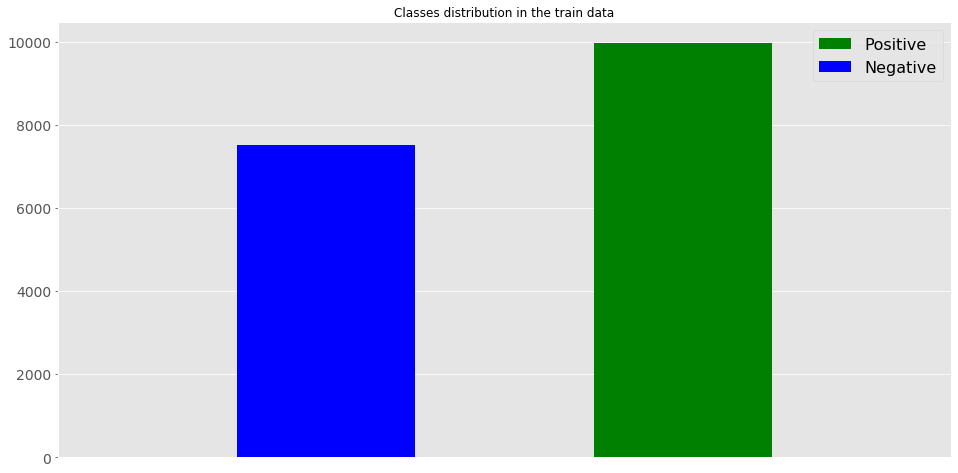

In [6]:
plt.hist(train[train.user_suggestion == 1].user_suggestion,
         bins=2, color='green', label='Positive')
plt.hist(train[train.user_suggestion == 0].user_suggestion,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=SMALL_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [7]:
X_train = train[['user_review']]
y_train = train[['user_suggestion']]

In [8]:
word_vect = TfidfVectorizer(strip_accents ='unicode', 
                            min_df=5, 
                            stop_words='english', 
                            analyzer='word', 
                            ngram_range = (1,2), 
                            sublinear_tf = True)


word_vect.fit(X_train['user_review'])
X_train_word_features = word_vect.transform(X_train['user_review'])

In [9]:
feature_names = np.array(word_vect.get_feature_names())
print(len(word_vect.get_feature_names()))

33812


In [10]:
feature_names = np.array(word_vect.get_feature_names())
print('Some elements of feature names in word vectorizer are:\n{}\n'.format(feature_names[::200]))

Some elements of feature names in word vectorizer are:
['00' '13 hours' '2d games' '70 hours' 'absolutely recommend'
 'access reviewwow' 'actually think' 'aggressively' 'altho' 'apparently'
 'asia' 'average 10' 'bad worse' 'basically play' 'best equipment'
 'better real' 'blame' 'bots battle' 'budget' 'buy coins' 'caps' 'cart'
 'change better' 'checking game' 'cliche' 'combatants' 'compared card'
 'confirm' 'control car' 'count times' 'crit' 'daily dungeon'
 'decent deck' 'definitely recommended' 'developers dont' 'didn start'
 'directions' 'does really' 'don people' 'dps' 'dwellers' 'effective'
 'engage' 'especially don' 'exp' 'extremely grindy' 'fan games'
 'feel good' 'finely' 'fo' 'frame rates' 'friend game' 'fun don'
 'fun worth' 'game awesome' 'game date' 'game fly' 'game involves'
 'game neverwinter' 'game release' 'game talking' 'gamemodes just'
 'games little' 'generally good' 'giving players' 'gone downhill'
 'good pc' 'goto' 'great honestly' 'grip' 'hackers game' 'hate like'

In [12]:
char_vect = TfidfVectorizer(strip_accents ='unicode', 
                            min_df=5, 
                            stop_words='english', 
                            analyzer='char', 
                            ngram_range = (3,6), 
                            sublinear_tf = True, 
                            max_features = 10000)


char_vect.fit(X_train['user_review'])
X_train_char_features = char_vect.transform(X_train['user_review'])

/root/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [14]:
## Stacking for the arrays together
X_train_final = hstack([X_train_word_features, X_train_char_features, X_train.drop(columns = 'user_review')])

In [15]:
model_logistic = LogisticRegression(C = 0.1, multi_class = 'multinomial', solver = 'lbfgs')
cv_score = np.mean(cross_val_score(model_logistic, X_train_final, y_train, cv=10, scoring='accuracy'))
print(cv_score)

/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

0.813247243322715


In [16]:
model_NB = MultinomialNB()
cv_score = np.mean(cross_val_score(model_NB, X_train_final, y_train, cv=10, scoring='accuracy'))
print(cv_score)

/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

0.778606910071061


In [17]:
model_random_forest = RandomForestClassifier(n_estimators=500, min_samples_leaf = 5,max_depth=7)
model_random_forest.fit(X_train_final, y_train)

model_random_forest.score(X_train_final, y_train)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7603749857093861

In [21]:
model_random_forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
model_logistic = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
model_logistic.fit(X_train_word_features, y_train)
sorted_coef_index = model_logistic.coef_[0].argsort()
print('Words with Smallest Coefs values are :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Words with Largest Coefs values are : \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Words with Smallest Coefs values are :
['worst' 'money' 'terrible' 'ruined' 'worse' 'pay' 'boring' 'garbage'
 'poor' 'waste']

Words with Largest Coefs values are : 
['best' 'great' 'amazing' 'free' 'love' 'easy' 'pubg' 'ships' 'addictive'
 'highly']



/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [19]:
sorted_tfidf_index = X_train_word_features.max(0).toarray()[0].argsort()
print('Words with smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Words with largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))


Words with smallest tfidf:
['mono' 'decent fast' 'rich boiiiiii' 'master difficult' 'walls better'
 'boiiiiii' 'average long' 'grind care' 'short average' 'floating average']

Words with largest tfidf: 
['yeah' 'access' 'то' 'medic' 'liked' 'join' 'max' 'x2' 'crash' 'bad']


In [22]:
X = train['user_review']
y = train['user_suggestion']

In [23]:
token = Tokenizer()
token.fit_on_texts(X)


In [24]:
word_index = token.word_index
vocab_size = len(word_index) + 1
sequences = token.texts_to_sequences(X)

In [25]:
max_len = 0
for i in sequences:
    x = len(i)
    if x > max_len:
        max_len = x
    else:
        continue
max_len

1600

In [26]:
padded_X = pad_sequences(sequences, maxlen = max_len, padding = 'post')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size = 0.2, random_state = 0)

In [28]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)


X_train size: (13995, 1600)
y_train size: (13995,)
X_test size: (3499, 1600)
y_test size: (3499,)


In [29]:
flat_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
flat_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
flat_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1600, 100)         5910200   
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 160000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                5120032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 11,030,331
Trainable params: 11,030,331
Non-trainable params: 0
____________________________________________

In [30]:
flat_model_fit = flat_model.fit(X_train, y_train, epochs = 10, validation_split = 0.2)

Train on 11196 samples, validate on 2799 samples
Epoch 1/10
11196/11196 [==============================] - 30s 3ms/sample - loss: 0.6487 - accuracy: 0.6294 - val_loss: 0.4156 - val_accuracy: 0.8214
Epoch 2/10
11196/11196 [==============================] - 29s 3ms/sample - loss: 0.3005 - accuracy: 0.8775 - val_loss: 0.3859 - val_accuracy: 0.8364
Epoch 3/10
11196/11196 [==============================] - 29s 3ms/sample - loss: 0.0985 - accuracy: 0.9702 - val_loss: 0.4961 - val_accuracy: 0.8203
Epoch 4/10
11196/11196 [==============================] - 29s 3ms/sample - loss: 0.0197 - accuracy: 0.9971 - val_loss: 0.6047 - val_accuracy: 0.8317
Epoch 5/10
11196/11196 [==============================] - 29s 3ms/sample - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.6923 - val_accuracy: 0.8307
Epoch 6/10
11196/11196 [==============================] - 28s 3ms/sample - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.7873 - val_accuracy: 0.8332
Epoch 7/10
11196/11196 [==============================] -

In [34]:
loss, accuracy = flat_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8434


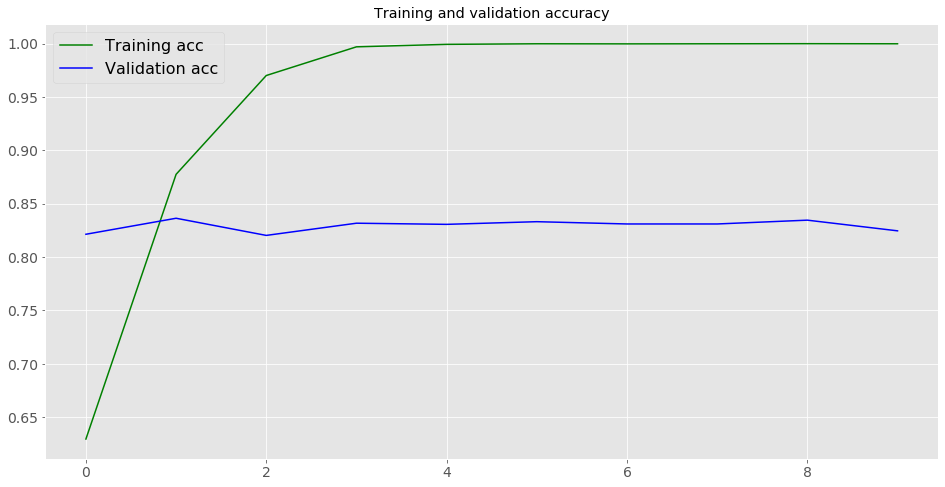

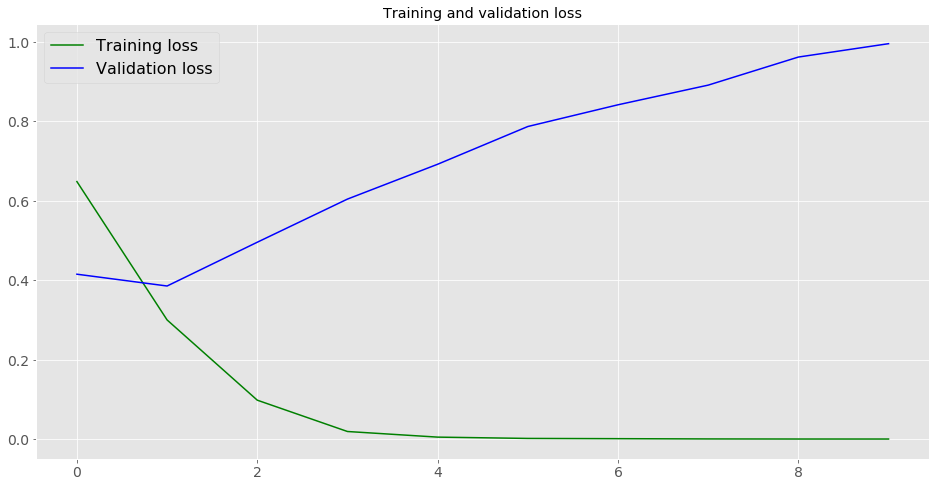

In [31]:
# Plot train/test loss and accuracy
acc = flat_model_fit.history['accuracy']
val_acc = flat_model_fit.history['val_accuracy']
loss = flat_model_fit.history['loss']
val_loss = flat_model_fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
    tf.keras.layers.LSTM(256, dropout = 0.2, recurrent_dropout = 0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1600, 100)         5910200   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 6,276,539
Trainable params: 6,276,539
Non-trainable params: 0
_________________________________________________________________


In [35]:
lstm_model_fit = lstm_model.fit(X_train, y_train, epochs = 10, validation_split = 0.2)

Train on 11196 samples, validate on 2799 samples
Epoch 1/10
11196/11196 [==============================] - 1463s 131ms/sample - loss: 0.6975 - accuracy: 0.5501 - val_loss: 0.6866 - val_accuracy: 0.5752
Epoch 2/10
11196/11196 [==============================] - 1448s 129ms/sample - loss: 0.6887 - accuracy: 0.5540 - val_loss: 0.6914 - val_accuracy: 0.5752
Epoch 3/10
11196/11196 [==============================] - 1446s 129ms/sample - loss: 0.6873 - accuracy: 0.5610 - val_loss: 0.6895 - val_accuracy: 0.5752
Epoch 4/10
11196/11196 [==============================] - 1437s 128ms/sample - loss: 0.6870 - accuracy: 0.5636 - val_loss: 0.6844 - val_accuracy: 0.5752
Epoch 5/10
11196/11196 [==============================] - 1442s 129ms/sample - loss: 0.6858 - accuracy: 0.5643 - val_loss: 0.6820 - val_accuracy: 0.5752
Epoch 6/10
11196/11196 [==============================] - 1440s 129ms/sample - loss: 0.6864 - accuracy: 0.5677 - val_loss: 0.6827 - val_accuracy: 0.5752
Epoch 7/10
11196/11196 [=========

In [36]:
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5696


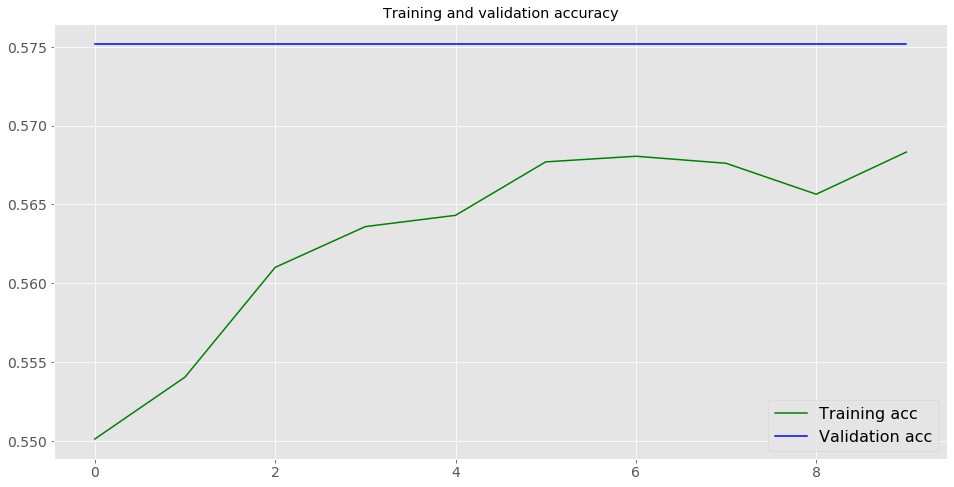

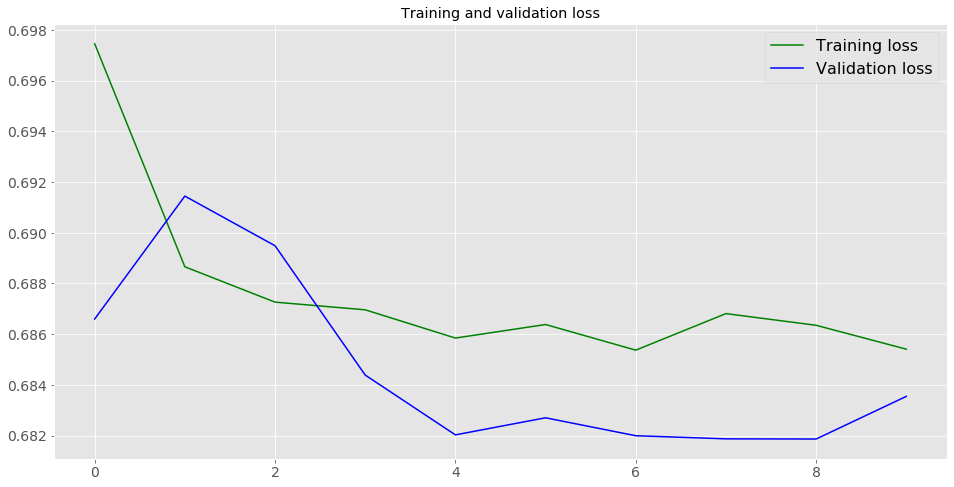

In [37]:
# Plot train/test loss and accuracy
acc = lstm_model_fit.history['accuracy']
val_acc = lstm_model_fit.history['val_accuracy']
loss = lstm_model_fit.history['loss']
val_loss = lstm_model_fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
    tf.keras.layers.Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.5)),
    tf.keras.layers.Dense(3, activation='softmax')
])
bi_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1600, 100)         5910200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 5,995,067
Trainable params: 5,995,067
Non-trainable params: 0
_________________________________________________________________


In [39]:
bi_lstm_model_fit = bi_lstm_model.fit(X_train, y_train, epochs = 10, validation_split = 0.2)

Train on 11196 samples, validate on 2799 samples
Epoch 1/10
11196/11196 [==============================] - 1500s 134ms/sample - loss: 0.5979 - accuracy: 0.6779 - val_loss: 0.4624 - val_accuracy: 0.7753
Epoch 2/10
11196/11196 [==============================] - 1483s 132ms/sample - loss: 0.4008 - accuracy: 0.8275 - val_loss: 0.4583 - val_accuracy: 0.7914
Epoch 3/10
11196/11196 [==============================] - 1481s 132ms/sample - loss: 0.3066 - accuracy: 0.8749 - val_loss: 0.4638 - val_accuracy: 0.8035
Epoch 4/10
11196/11196 [==============================] - 1483s 132ms/sample - loss: 0.2363 - accuracy: 0.9090 - val_loss: 0.5002 - val_accuracy: 0.7899
Epoch 5/10
11196/11196 [==============================] - 1483s 132ms/sample - loss: 0.2072 - accuracy: 0.9217 - val_loss: 0.5684 - val_accuracy: 0.7889
Epoch 6/10
11196/11196 [==============================] - 1479s 132ms/sample - loss: 0.1527 - accuracy: 0.9470 - val_loss: 0.6631 - val_accuracy: 0.7806
Epoch 7/10
11196/11196 [=========

In [40]:
loss, accuracy = bi_lstm_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7988


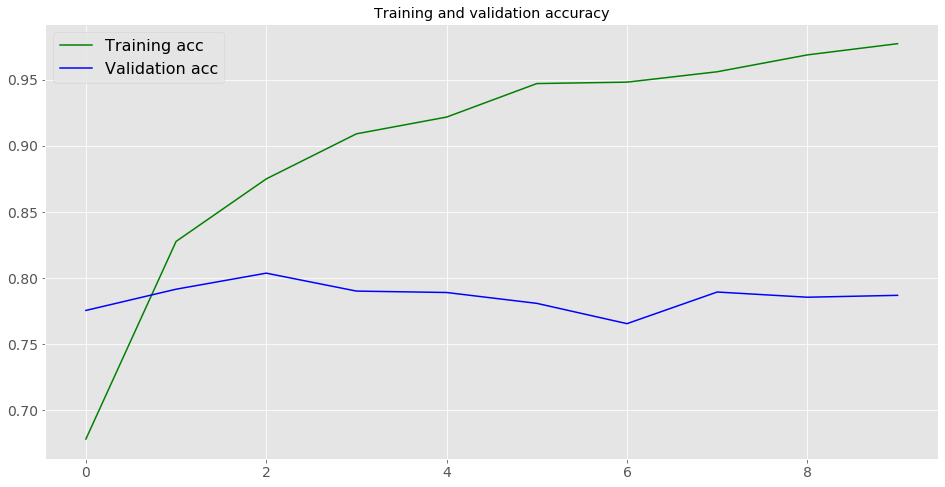

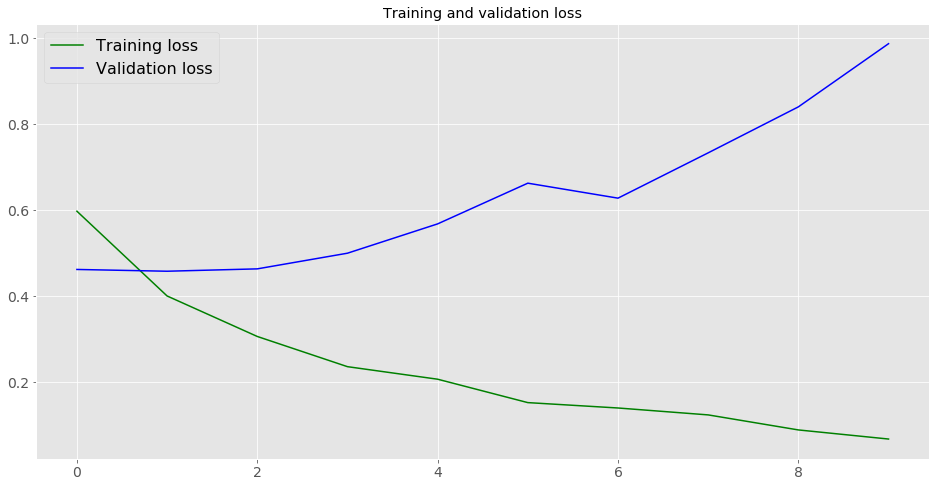

In [41]:
# Plot train/test loss and accuracy
acc = bi_lstm_model_fit.history['accuracy']
val_acc = bi_lstm_model_fit.history['val_accuracy']
loss = bi_lstm_model_fit.history['loss']
val_loss = bi_lstm_model_fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()